In [0]:
import pandas as pd
import numpy as np

import snowflake.snowpark as snp
from snowflake.snowpark import types as T
from snowflake.snowpark.types import *
from snowflake.snowpark.session import Session
from snowflake.snowpark import Window


from snowflake.snowpark.functions import ceil, col, pandas_udf
from pyspark.ml.feature import VectorAssembler
from synapse.ml.lightgbm import LightGBMClassifier
import onnx
import matplotlib.pyplot as plt
import seaborn as sns

/databricks/python/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1)
 warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "

## Bring data from Snowflake using Snowpark

In [0]:
sfUser = dbutils.secrets.get("snowflake", "SNOW-AZURE-STROKE-USERNAME")
sfPassword = dbutils.secrets.get("snowflake", "SNOW-AZURE-STROKE-PASSWORD")
sfAccount = dbutils.secrets.get("snowflake", "SNOW-AZURE-STROKE-ACCOUNT")
sfDatabase = dbutils.secrets.get("snowflake", "SNOW-AZURE-STROKE-DB")
sfSchema = dbutils.secrets.get("snowflake", "SNOW-AZURE-STROKE-SCHEMA")
sfTrainingWarehouse = dbutils.secrets.get("snowflake", "SNOW-AZURE-STROKE-TRAINING-WAREHOUSE")
sfRole = dbutils.secrets.get("snowflake", "SNOW-AZURE-STROKE-ROLE")
sfURL = dbutils.secrets.get("snowflake", "SNOW-AZURE-STROKE-URL")

In [0]:
SNOWPARK_CONNECTION_PARAMETERS = {
    'account': sfAccount,
    'user': sfUser,
    'password': sfPassword,
    'schema': sfSchema,
    'database': sfDatabase,
    'warehouse': sfTrainingWarehouse,
    'role': sfRole
}
session = Session.builder.configs(SNOWPARK_CONNECTION_PARAMETERS).create()

## Check the data

In [0]:
raw_table_name = 'STROKE'
stroke_snowdf = session.table(raw_table_name)
stroke_snowdf.limit(10).to_pandas()

Out[4]:

,ID,GENDER,AGE,HYPERTENSION,HEART_DISEASE,EVER_MARRIED,WORK_TYPE,RESIDENCE_TYPE,AVG_GLUCOSE_LEVEL,BMI,SMOKING_STATUS,STROKE
0,30669,Male,3,0,0,No,children,Rural,95.12,18,None,0
1,30468,Male,58,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8,0,0,No,Private,Urban,110.89,17.6,None,0
3,56543,Female,70,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14,0,0,No,Never_worked,Rural,161.28,19.1,None,0
5,32257,Female,47,0,0,Yes,Private,Urban,210.95,50.1,None,0
6,52800,Female,52,0,0,Yes,Private,Urban,77.59,17.7,formerly smoked,0
7,41413,Female,75,0,1,Yes,Self-employed,Rural,243.53,27,never smoked,0
8,15266,Female,32,0,0,Yes,Private,Rural,77.67,32.3,smokes,0
9,28674,Female,74,1,0,Yes,Self-employed,Urban,205.84,54.6,never smoked,0


In [0]:
stroke_snowdf.filter(col("STROKE")==1).limit(10).to_pandas()

Out[5]:

,ID,GENDER,AGE,HYPERTENSION,HEART_DISEASE,EVER_MARRIED,WORK_TYPE,RESIDENCE_TYPE,AVG_GLUCOSE_LEVEL,BMI,SMOKING_STATUS,STROKE
0,9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,None,never smoked,1
2,31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24,never smoked,1
5,56669,Male,81,0,0,Yes,Private,Urban,186.21,29,formerly smoked,1
6,53882,Male,74,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59,0,0,Yes,Private,Rural,76.15,None,None,1
9,60491,Female,78,0,0,Yes,Private,Urban,58.57,24.2,None,1


In [0]:
stroke_snowdf.schema

Out[6]: StructType([StructField('ID', LongType(), nullable=True), StructField('GENDER', StringType(), nullable=True), StructField('AGE', LongType(), nullable=True), StructField('HYPERTENSION', LongType(), nullable=True), StructField('HEART_DISEASE', LongType(), nullable=True), StructField('EVER_MARRIED', StringType(), nullable=True), StructField('WORK_TYPE', StringType(), nullable=True), StructField('RESIDENCE_TYPE', StringType(), nullable=True), StructField('AVG_GLUCOSE_LEVEL', DoubleType(), nullable=True), StructField('BMI', StringType(), nullable=True), StructField('SMOKING_STATUS', StringType(), nullable=True), StructField('STROKE', LongType(), nullable=True)])

## Step1: Push-Down preprocessing/feature engineering with Snowpark

#### Lets convert gender, ever_married, work_type, residence_type and smoking_status into label encoded columns

In [0]:
dbutils.fs.ls("/snowpark/preprocessing/")
import sys
sys.path.append('/dbfs/snowpark/')

Lets perform label encoding

In [0]:
import preprocessing as pp
le_gender = pp.LabelEncoder(input_col="GENDER", output_col="GENDER_ENCODED")
le_ever_married = pp.LabelEncoder(input_col="EVER_MARRIED", output_col="EVER_MARRIED_ENCODED")
le_work_type = pp.LabelEncoder(input_col="WORK_TYPE", output_col="WORK_TYPE_ENCODED")
le_residence_type = pp.LabelEncoder(input_col="RESIDENCE_TYPE", output_col="RESIDENCE_TYPE_ENCODED")
le_smoking_status = pp.LabelEncoder(input_col="SMOKING_STATUS", output_col="SMOKING_STATUS_ENCODED")

le_gender.fit(stroke_snowdf)
stroke_snowdf_labelencoded = le_gender.transform(stroke_snowdf)
le_ever_married.fit(stroke_snowdf_labelencoded)
stroke_snowdf_labelencoded = le_ever_married.transform(stroke_snowdf_labelencoded)
le_work_type.fit(stroke_snowdf_labelencoded)
stroke_snowdf_labelencoded = le_work_type.transform(stroke_snowdf_labelencoded)
le_residence_type.fit(stroke_snowdf_labelencoded)
stroke_snowdf_labelencoded = le_residence_type.transform(stroke_snowdf_labelencoded)
le_smoking_status.fit(stroke_snowdf_labelencoded)
stroke_snowdf_labelencoded = le_smoking_status.transform(stroke_snowdf_labelencoded)

columns_excluded = ['ID', 'GENDER', 'EVER_MARRIED', 'WORK_TYPE', 'RESIDENCE_TYPE', 'SMOKING_STATUS']
included_columns = [c for c in stroke_snowdf_labelencoded.columns if c not in columns_excluded]

stroke_snowdf_labelencoded = stroke_snowdf_labelencoded.select(*included_columns) \
                            .with_column_renamed(col("GENDER_ENCODED"), "GENDER") \
                            .with_column_renamed(col("EVER_MARRIED_ENCODED"), "EVER_MARRIED")\
                            .with_column_renamed(col("WORK_TYPE_ENCODED"), "WORK_TYPE")\
                            .with_column_renamed(col("RESIDENCE_TYPE_ENCODED"), "RESIDENCE_TYPE")\
                            .with_column_renamed(col("SMOKING_STATUS_ENCODED"), "SMOKING_STATUS")
stroke_snowdf_labelencoded.limit(10).to_pandas()

Out[8]:

,AGE,HYPERTENSION,HEART_DISEASE,AVG_GLUCOSE_LEVEL,BMI,STROKE,GENDER,EVER_MARRIED,WORK_TYPE,RESIDENCE_TYPE,SMOKING_STATUS
0,3,0,0,95.12,18,0,1,0,4,0,NaN
1,58,1,0,87.96,39.2,0,1,1,2,1,1.0
2,8,0,0,110.89,17.6,0,0,0,2,1,NaN
3,70,0,0,69.04,35.9,0,0,1,2,0,0.0
4,14,0,0,161.28,19.1,0,1,0,1,0,NaN
5,47,0,0,210.95,50.1,0,0,1,2,1,NaN
6,52,0,0,77.59,17.7,0,0,1,2,1,0.0
7,75,0,1,243.53,27,0,0,1,3,0,1.0
8,32,0,0,77.67,32.3,0,0,1,2,0,2.0
9,74,1,0,205.84,54.6,0,0,1,3,1,1.0


In [0]:
stroke_snowdf_labelencoded.count()

Out[9]: 43400

In [0]:
stroke_snowdf_processed = stroke_snowdf_labelencoded.filter(col('age')>2)
stroke_snowdf_processed.count()

Out[10]: 41796

#### Missing Data Management with Snowpark

In [0]:
stroke_missing_removed_snowdf = stroke_snowdf_processed.na.drop()
stroke_missing_removed_snowdf.count()

Out[11]: 29072

In [0]:
stroke_missing_removed_snowdf = stroke_missing_removed_snowdf.with_column('BMI', col('BMI').cast('float'))
stroke_missing_removed_snowdf.describe(['BMI']).limit(10).to_pandas()

Out[12]:

,SUMMARY,BMI
0,count,29072.000000
1,mean,30.054166
2,stddev,7.193908
3,min,10.100000
4,max,92.000000


In [0]:
stroke_missing_removed_snowdf.count()

Out[13]: 29072

In [0]:
snow_features_original_table_name = 'stroke_features'
featureColumns = ['GENDER','AGE', 'HYPERTENSION', 'HEART_DISEASE', 'EVER_MARRIED', 'WORK_TYPE', 'RESIDENCE_TYPE', 'AVG_GLUCOSE_LEVEL', 'BMI', 'SMOKING_STATUS', 'STROKE']
stroke_missing_removed_snowdf.select(*featureColumns).write.save_as_table(snow_features_original_table_name, mode="overwrite")
stroke_snowdf = session.table(snow_features_original_table_name)
stroke_snowdf.limit(10).to_pandas()

Out[14]:

,GENDER,AGE,HYPERTENSION,HEART_DISEASE,EVER_MARRIED,WORK_TYPE,RESIDENCE_TYPE,AVG_GLUCOSE_LEVEL,BMI,SMOKING_STATUS,STROKE
0,1,58,1,0,1,2,1,87.96,39.2,1,0
1,0,70,0,0,1,2,0,69.04,35.9,0,0
2,0,52,0,0,1,2,1,77.59,17.7,0,0
3,0,75,0,1,1,3,0,243.53,27.0,1,0
4,0,32,0,0,1,2,0,77.67,32.3,2,0
5,0,74,1,0,1,3,1,205.84,54.6,1,0
6,1,79,0,1,1,2,1,57.08,22.0,0,0
7,0,37,0,0,1,2,0,162.96,39.4,1,0
8,0,37,0,0,1,2,0,73.50,26.1,0,0
9,0,40,0,0,1,2,0,95.04,42.4,1,0


#### Synthetic Minority Oversampling Technique (SMOTE) with Snowpark Stored Procedure

In [0]:
# We have highly imbalanced data
stroke_snowdf.group_by('stroke').count().to_pandas()

Out[15]:

,STROKE,COUNT
0,0,28524
1,1,548


In [0]:
session.sql('CREATE OR REPLACE STAGE ML_PROCS').collect()
pd.DataFrame(session.sql('SHOW STAGES').collect())

Out[16]:

,created_on,name,database_name,schema_name,url,has_credentials,has_encryption_key,owner,comment,region,type,cloud,notification_channel,storage_integration
0,2022-11-01 10:02:04.562000-07:00,DATA_STAGE,[REDACTED],[REDACTED],,N,N,[REDACTED],,None,INTERNAL,None,None,None
1,2023-01-31 18:16:02.011000-08:00,FUNCTIONS,[REDACTED],[REDACTED],,N,N,[REDACTED],,None,INTERNAL,None,None,None
2,2023-02-01 11:58:25.211000-08:00,ML_PROCS,[REDACTED],[REDACTED],,N,N,[REDACTED],,None,INTERNAL,None,None,None


In [0]:
# This local Python-function will be registered as a Stored Procedure and runs in Snowflake

def sproc_oversample_smote(session: Session, 
                           training_table: str, 
                           feature_cols: list,
                           target_col: str,
                           target_table: str) -> T.Variant:
    
    # Loading data into pandas dataframe
    local_training_data = session.table(training_table).to_pandas()

    # Define features and label
    X = local_training_data[feature_cols]
    y = local_training_data[target_col]
    
    # Oversample minority class via SMOTE
    from imblearn.over_sampling import SMOTE
    X_balance, y_balance = SMOTE().fit_resample(X,y)
    
    # Combine return values into single pandas dataframe
    X_balance[target_col] = y_balance
    
    # Persist dataframe in Snowflake table
    session.sql('DROP TABLE IF EXISTS {}'.format(target_table)).collect()
    session.write_pandas(X_balance, table_name=target_table, auto_create_table=True)
    
    # Getting model coefficients
    return "Successfully oversampled"

In [0]:
# Get the path of imblearn package
import imblearn
imblearn_path = imblearn.__path__[0]
print(imblearn_path)

/databricks/python/lib/python3.8/site-packages/imblearn

In [0]:
# Registering the function as a Stored Procedure
sproc_oversample_smote = session.sproc.register(func=sproc_oversample_smote, 
                                                name='sproc_oversample_smote', 
                                                is_permanent=True, 
                                                replace=True,
                                                stage_location='@ML_PROCS',
                                                packages=['snowflake-snowpark-python','scikit-learn==1.1.1'],
                                                imports=[imblearn_path])

In [0]:
##Switch to high memory warehouse for Snowpark Stored procedure using session.use_warehouse(HIGH_MEM_WH) which provides around 230GB of RAM to do in memory computation

In [0]:
training_table = snow_features_original_table_name
# get feature columns
feature_cols = stroke_snowdf.columns
feature_cols.remove('STROKE')
target_col = 'STROKE'
target_table = 'STROKE_RESAMPLED_FEATURES'

sproc_oversample_smote(training_table, 
                       feature_cols, 
                       target_col,
                       target_table, 
                       session=session)

Out[21]: '"Successfully oversampled"'

In [0]:
##Move back to standward warehouse in snowflake using session.use_warehouse(STANDARD_WH)

#### Preprocessing complete: Checking the Resampled Data

In [0]:
# Now our training data is balanced
rebalanced_snow_sdf = session.table(target_table)
rebalanced_snow_sdf.limit(10).to_pandas()

Out[23]:

,GENDER,AGE,HYPERTENSION,HEART_DISEASE,EVER_MARRIED,WORK_TYPE,RESIDENCE_TYPE,AVG_GLUCOSE_LEVEL,BMI,SMOKING_STATUS,STROKE
0,1,58,1,0,1,2,1,87.96,39.2,1,0
1,0,70,0,0,1,2,0,69.04,35.9,0,0
2,0,52,0,0,1,2,1,77.59,17.7,0,0
3,0,75,0,1,1,3,0,243.53,27.0,1,0
4,0,32,0,0,1,2,0,77.67,32.3,2,0
5,0,74,1,0,1,3,1,205.84,54.6,1,0
6,1,79,0,1,1,2,1,57.08,22.0,0,0
7,0,37,0,0,1,2,0,162.96,39.4,1,0
8,0,37,0,0,1,2,0,73.50,26.1,0,0
9,0,40,0,0,1,2,0,95.04,42.4,1,0


In [0]:
# We have balanced data
rebalanced_snow_sdf.group_by('stroke').count().to_pandas()

Out[27]:

,STROKE,COUNT
0,0,28524
1,1,28524


In [0]:
weights = [0.8, 0.2]
rebalanced_snow_sdf_parts = rebalanced_snow_sdf.random_split(weights)
training_snowdf = rebalanced_snow_sdf_parts[0]
testing_snowdf = rebalanced_snow_sdf_parts[1]
training_table_name = "ONNX_TRAIN_STROKE"
testing_table_name = "ONNX_TEST_STROKE"
training_snowdf.write.save_as_table(training_table_name, mode="overwrite")
testing_snowdf.write.save_as_table(testing_table_name, mode="overwrite")

In [0]:
training_snowdf.schema

Out[32]: StructType([StructField('GENDER', LongType(), nullable=True), StructField('AGE', LongType(), nullable=True), StructField('HYPERTENSION', LongType(), nullable=True), StructField('HEART_DISEASE', LongType(), nullable=True), StructField('EVER_MARRIED', LongType(), nullable=True), StructField('WORK_TYPE', LongType(), nullable=True), StructField('RESIDENCE_TYPE', LongType(), nullable=True), StructField('AVG_GLUCOSE_LEVEL', DoubleType(), nullable=True), StructField('BMI', DoubleType(), nullable=True), StructField('SMOKING_STATUS', LongType(), nullable=True), StructField('STROKE', LongType(), nullable=True)])

## Step2: Model Training with PySpark (SynapseML LightGBMClassifier)

#### Lets get the feature engineering data from Snowflake using Spark connector for model training with PySpark

In [0]:
SPARK_CONNECTOR_OPTIONS = {
  "sfUrl": sfURL,
  "sfUser": sfUser,
  "sfPassword": sfPassword,
  "sfDatabase": sfDatabase,
  "sfSchema": sfSchema,
  "sfWarehouse": sfTrainingWarehouse,
  "sfRole": sfRole
}

featureng_sparkdf_from_snowflake = spark.read \
  .format("snowflake") \
  .options(**SPARK_CONNECTOR_OPTIONS) \
  .option("dbtable", training_table_name) \
  .load()

In [0]:
featureng_sparkdf_from_snowflake.printSchema

Out[33]: <bound method DataFrame.printSchema of DataFrame[GENDER: decimal(38,0), AGE: decimal(38,0), HYPERTENSION: decimal(38,0), HEART_DISEASE: decimal(38,0), EVER_MARRIED: decimal(38,0), WORK_TYPE: decimal(38,0), RESIDENCE_TYPE: decimal(38,0), AVG_GLUCOSE_LEVEL: double, BMI: double, SMOKING_STATUS: decimal(38,0), STROKE: decimal(38,0)]>

In [0]:
from pyspark.sql.dataframe import DataFrame as SparkDataFrame
from pyspark.sql.functions import col as SparkCol
from pyspark.sql.types import DecimalType as SparkDecimalType
from pyspark.sql.types import IntegerType as SparkIntegerType
def convert_decimaltyes_with_38_precision_and_zero_scale_to_integer_types(sdf: SparkDataFrame) -> SparkDataFrame:
    for c in sdf.columns:
        if sdf.schema[c].dataType == SparkDecimalType(38,0):
            sdf = sdf.withColumn(c, SparkCol(c).cast(SparkIntegerType()))
    return sdf

In [0]:
training_sparkdf = convert_decimaltyes_with_38_precision_and_zero_scale_to_integer_types(featureng_sparkdf_from_snowflake)
display(training_sparkdf.head(5))

GENDER,AGE,HYPERTENSION,HEART_DISEASE,EVER_MARRIED,WORK_TYPE,RESIDENCE_TYPE,AVG_GLUCOSE_LEVEL,BMI,SMOKING_STATUS,STROKE
1,58,1,0,1,2,1,87.96,39.2,1,0
0,52,0,0,1,2,1,77.59,17.7,0,0
0,75,0,1,1,3,0,243.53,27.0,1,0
0,74,1,0,1,3,1,205.84,54.6,1,0
1,79,0,1,1,2,1,57.08,22.0,0,0


In [0]:
target_col = 'STROKE'
feature_cols = training_sparkdf.drop(target_col).columns
featurizer = VectorAssembler(inputCols = feature_cols, outputCol = "features")
training_sparkdf = featurizer.transform(training_sparkdf)["STROKE", "features"]

In [0]:
display(training_sparkdf.head(10))

STROKE,features
0,"Map(vectorType -> dense, length -> 10, values -> List(1.0, 58.0, 1.0, 0.0, 1.0, 2.0, 1.0, 87.96, 39.2, 1.0))"
0,"Map(vectorType -> dense, length -> 10, values -> List(0.0, 52.0, 0.0, 0.0, 1.0, 2.0, 1.0, 77.59, 17.7, 0.0))"
0,"Map(vectorType -> dense, length -> 10, values -> List(0.0, 75.0, 0.0, 1.0, 1.0, 3.0, 0.0, 243.53, 27.0, 1.0))"
0,"Map(vectorType -> dense, length -> 10, values -> List(0.0, 74.0, 1.0, 0.0, 1.0, 3.0, 1.0, 205.84, 54.6, 1.0))"
0,"Map(vectorType -> dense, length -> 10, values -> List(1.0, 79.0, 0.0, 1.0, 1.0, 2.0, 1.0, 57.08, 22.0, 0.0))"
0,"Map(vectorType -> sparse, length -> 10, indices -> List(1, 4, 5, 7, 8), values -> List(37.0, 1.0, 2.0, 73.5, 26.1))"
0,"Map(vectorType -> dense, length -> 10, values -> List(0.0, 40.0, 0.0, 0.0, 1.0, 2.0, 0.0, 95.04, 42.4, 1.0))"
0,"Map(vectorType -> dense, length -> 10, values -> List(1.0, 35.0, 0.0, 0.0, 0.0, 2.0, 0.0, 85.37, 33.0, 1.0))"
0,"Map(vectorType -> dense, length -> 10, values -> List(0.0, 20.0, 0.0, 0.0, 0.0, 2.0, 1.0, 84.62, 19.7, 2.0))"
0,"Map(vectorType -> dense, length -> 10, values -> List(0.0, 42.0, 0.0, 0.0, 1.0, 2.0, 0.0, 82.67, 22.5, 1.0))"


#### Use LightGBM to train a model

In [0]:
model = (
    LightGBMClassifier(featuresCol="features", labelCol="STROKE")
    .setEarlyStoppingRound(300)
    .setLambdaL1(0.5)
    .setNumIterations(1000)
    .setNumThreads(-1)
    .setMaxDeltaStep(0.5)
    .setNumLeaves(31)
    .setMaxDepth(-1)
    .setBaggingFraction(0.7)
    .setFeatureFraction(0.7)
    .setBaggingFreq(2)
    .setObjective("binary")
    .setIsUnbalance(True)
    .setMinSumHessianInLeaf(20)
    .setMinGainToSplit(0.01)
)

model = model.fit(training_sparkdf)

## Step 3: Export to ONNX model

In [0]:
from synapse.ml.core.platform import running_on_binder

if running_on_binder():
    !pip install lightgbm==3.2.1
    from IPython import get_ipython
import lightgbm as lgb
from lightgbm import Booster, LGBMClassifier


def convertModel(lgbm_model: LGBMClassifier or Booster, input_size: int) -> bytes:
    from onnxmltools.convert import convert_lightgbm
    from onnxconverter_common.data_types import FloatTensorType

    initial_types = [("input", FloatTensorType([-1, input_size]))]
    onnx_model = convert_lightgbm(
        lgbm_model, initial_types=initial_types, target_opset=9
    )
    return onnx_model.SerializeToString()


booster_model_str = model.getLightGBMBooster().modelStr().get()
booster = lgb.Booster(model_str=booster_model_str)
model_payload_ml = convertModel(booster, len(feature_cols))

Finished loading model, total used 1000 iterations

#### Write the model to databricks driver for snowpark to pick it up

In [0]:
with open("pipeline_lightgbm.onnx", "wb") as f:
    f.write(model_payload_ml)

## Step 4: Snowpark Vectorized UDF that brings in ONNX model (to perform distributed batch predictions)

In [0]:
# Create a Snowflake stage to store functions
session.sql('CREATE OR REPLACE STAGE FUNCTIONS').collect()

Out[47]: [Row(status='Stage area FUNCTIONS successfully created.')]

In [0]:
from cachetools import cached

@cached(cache={})
def load_model(model_path: str) -> object:
    # Load ONNX model
    import onnxruntime as rt
    # Adjust session options (use only 1 Thread for best performance)
    opts = rt.SessionOptions()
    opts.intra_op_num_threads = 1
    providers = ['CPUExecutionProvider']
    model = rt.InferenceSession(model_path, providers=providers, sess_options=opts)
    return model

@pandas_udf(name='SCORE_ONNX_MODEL',
            stage_location='@FUNCTIONS',
            input_types=[T.FloatType()]*10, 
            return_type = T.IntegerType(), 
            replace=True, 
            is_permanent=True, 
            imports=['pipeline_lightgbm.onnx'],
            packages=['onnxruntime','cachetools','numpy'], 
            max_batch_size=10000, 
            session=session)
def score_onnx_model(df: pd.DataFrame) -> pd.Series:
    import sys
    import numpy as np
    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    model_name = '/pipeline_lightgbm.onnx'
    model = load_model(import_dir+model_name)
    return model.run(None, {"input": df.values.astype(np.float32)})[0]

The version of package numpy in the local environment is 1.24.1, which does not fit the criteria for the requirement numpy. Your UDF might not work when the package version is different between the server and your local environment

## Step 5: Native ONNX predictions within Snowflake

In [0]:
testing_snowdf = session.table(testing_table_name)
target_col = 'STROKE'
feature_cols =  testing_snowdf.drop(target_col).columns
snowpark_df_scored = testing_snowdf.with_column('PREDICTED_STROKE', score_onnx_model(*feature_cols))

In [0]:
snowpark_df_scored.limit(10).to_pandas()

Out[50]:

,GENDER,AGE,HYPERTENSION,HEART_DISEASE,EVER_MARRIED,WORK_TYPE,RESIDENCE_TYPE,AVG_GLUCOSE_LEVEL,BMI,SMOKING_STATUS,STROKE,PREDICTED_STROKE
0,0,70,0,0,1,2,0,69.04,35.9,0,0,0
1,0,32,0,0,1,2,0,77.67,32.3,2,0,0
2,0,37,0,0,1,2,0,162.96,39.4,1,0,0
3,0,38,0,0,0,2,0,97.49,26.9,1,0,0
4,1,58,1,0,0,2,1,55.78,27.5,2,0,0
5,0,32,0,0,1,2,0,62.60,25.1,0,0,0
6,0,23,0,0,0,2,1,94.09,30.9,1,0,0
7,1,59,0,0,1,2,1,117.92,29.4,2,0,0
8,1,58,1,0,1,0,0,56.96,26.8,2,0,0
9,1,44,0,0,1,2,0,81.84,25.1,1,0,0


#### See sample records were stroke was predicted

In [0]:
snowpark_df_scored.filter(col("PREDICTED_STROKE")==1).limit(10).to_pandas()

Out[51]:

,GENDER,AGE,HYPERTENSION,HEART_DISEASE,EVER_MARRIED,WORK_TYPE,RESIDENCE_TYPE,AVG_GLUCOSE_LEVEL,BMI,SMOKING_STATUS,STROKE,PREDICTED_STROKE
0,1,66,0,0,1,2,0,242.30,35.3,2,0,1
1,1,76,0,0,1,2,0,234.58,34.3,0,0,1
2,0,82,0,1,0,2,1,215.60,24.9,1,0,1
3,0,44,0,0,0,2,0,103.78,49.8,0,0,1
4,0,78,0,0,1,3,0,115.43,27.8,1,0,1
5,1,50,0,0,1,2,1,158.31,32.8,0,0,1
6,1,73,0,1,1,3,0,189.45,32.2,1,0,1
7,0,60,0,1,1,2,1,208.05,35.3,2,0,1
8,1,58,0,0,0,2,0,76.22,22.2,0,0,1
9,0,76,0,0,1,2,0,97.90,31.3,0,0,1


#### Save all predictions to a Snowflake table with Snowpark

In [0]:
results_table_name = "ONNX_PREDICTIONS_STROKE"
snowpark_df_scored.write.save_as_table(results_table_name, mode="overwrite")

#### Calculate classification metrics

In [0]:
# Define functions to calculate metrics
def accuracy_score(df, y_true, y_pred):
    conf_matrix = df.group_by([y_true,y_pred]).count().to_pandas()
    tn = int(conf_matrix.loc[(conf_matrix[y_true] == 0) & (conf_matrix[y_pred] == 0)]['COUNT'])
    fp = int(conf_matrix.loc[(conf_matrix[y_true] == 0) & (conf_matrix[y_pred] == 1)]['COUNT'])
    fn = int(conf_matrix.loc[(conf_matrix[y_true] == 1) & (conf_matrix[y_pred] == 0)]['COUNT'])
    tp = int(conf_matrix.loc[(conf_matrix[y_true] == 1) & (conf_matrix[y_pred] == 1)]['COUNT'])
    accuracy = (tp+tn) / (tp+tn+fn+fp)
    return accuracy

def precision_score(df, y_true, y_pred):
    conf_matrix = df.group_by([y_true,y_pred]).count().to_pandas()
    fp = int(conf_matrix.loc[(conf_matrix[y_true] == 0) & (conf_matrix[y_pred] == 1)]['COUNT'])
    tp = int(conf_matrix.loc[(conf_matrix[y_true] == 1) & (conf_matrix[y_pred] == 1)]['COUNT'])
    precision = tp / (tp+fp)
    return precision

def recall_score(df, y_true, y_pred):
    conf_matrix = df.group_by([y_true,y_pred]).count().to_pandas()
    tn = int(conf_matrix.loc[(conf_matrix[y_true] == 0) & (conf_matrix[y_pred] == 0)]['COUNT'])
    fn = int(conf_matrix.loc[(conf_matrix[y_true] == 1) & (conf_matrix[y_pred] == 0)]['COUNT'])
    tp = int(conf_matrix.loc[(conf_matrix[y_true] == 1) & (conf_matrix[y_pred] == 1)]['COUNT'])
    recall = tp / (tp+fn)
    return recall

def f1_score(df, y_true, y_pred):
    precision = precision_score(df, y_true=y_true, y_pred=y_pred)
    recall = recall_score(df, y_true=y_true, y_pred=y_pred)
    f1_score = (2*precision*recall) / (precision+recall)
    return f1_score

def confusion_matrix(df, y_true, y_pred):
    conf_matrix = df.group_by([y_true,y_pred]).count().to_pandas()
    tn = int(conf_matrix.loc[(conf_matrix[y_true] == 0) & (conf_matrix[y_pred] == 0)]['COUNT'])
    fp = int(conf_matrix.loc[(conf_matrix[y_true] == 0) & (conf_matrix[y_pred] == 1)]['COUNT'])
    fn = int(conf_matrix.loc[(conf_matrix[y_true] == 1) & (conf_matrix[y_pred] == 0)]['COUNT'])
    tp = int(conf_matrix.loc[(conf_matrix[y_true] == 1) & (conf_matrix[y_pred] == 1)]['COUNT'])
    conf_matrix = [[tn, fp], [fn, tp]]
    return conf_matrix

Accuracy: 0.9490817303507703
Precision: 0.928392588883325
Recall: 0.9727177334732424
F1: 0.9500384319754035

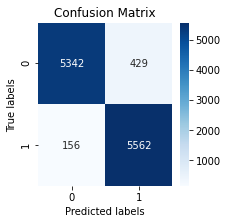

In [0]:
# Visualizing Confusion Matrix
cf_matrix = confusion_matrix(snowpark_df_scored, y_true='STROKE', y_pred='PREDICTED_STROKE')
fig, ax = plt.subplots(figsize=(3,3))
sns.heatmap(cf_matrix, annot=True, fmt='g', ax=ax, cmap='Blues')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Calculating Statistics
print('Accuracy:', accuracy_score(snowpark_df_scored, y_true='STROKE', y_pred='PREDICTED_STROKE'))
print('Precision:', precision_score(snowpark_df_scored, y_true='STROKE', y_pred='PREDICTED_STROKE'))
print('Recall:', recall_score(snowpark_df_scored, y_true='STROKE', y_pred='PREDICTED_STROKE'))
print('F1:', f1_score(snowpark_df_scored, y_true='STROKE', y_pred='PREDICTED_STROKE'))

In [0]:
session.close()